# Chapter 7. Ensemble Leaning and Random Forests

## 1. What is Ensemble Learning?

The idea is that if we aggegate the predictions of a group of predictors such as classifiers or regressors, we will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble* and this technique is called Ensemble Learning. An Ensemble Learning algorithm is called an Ensemble Method

An example of Ensemble Method is the Random Forest. We train a group of Decision Tree classifiers, each on a different random subset of the training set and take the majority vote class as the final prediction.

## 2. Voting Classifiers

## 2.1 Hard Voting Classifier

![figure7.1](images/figure7.1.png)

To create an even better classifier, we can aggregate the predictions of each classifier and predict the class that gets the most votes. This is called a hard voting classifier

![figure7.2](images/figure7.2.png)

- Even if each classifier is a weak learner (does only slightly better than randomly guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse

- Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors hence improving the ensemble's accuracy

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf_clf', rf_clf),
                ('svc', svm_clf)],
    voting="hard")

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf_clf', RandomForestClassifier()),
                             ('svc', SVC())])

Indivdual classifier's accuracy

In [5]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


## 2.2 Soft Voting Classifier

If all classifiers are able to estimate class probabilties, we can predict the class with the highest class probability, averaged over all the individual classifiers.

Soft voting classifier often achieves higher performance than hard voting because it gives more weight to highly confident votes.

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 3. Bagging and Pasting

- **Bagging (Bootstrap Aggregating)**: Sampling with replacement 
- **Pasting**: Sampling without replacement

![figure7.4](images/figure7.4.png)

The ensemble can make a prediction for a new instance by aggregating the predictions of all predcitors.  
- Classification: Majority Vote
- Regression: Average value

Aggregating reduces both bias and variance. The net result is that the ensemble has a similar bias but a lower variance than a single predcitor trained on the original training set.

Bagging Classifier automatically performs soft voting instead of hard voting if the base classifier can estimate probabiltiies.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier( 
    DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100, bootstrap=True, n_jobs=-1) # for pasting, bootstrap=False. n_jobs=-1 uses all CPU cores

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


## 3.1 Out-of-Bag Evaluation

Since a predictor never sees the oob instances during training, it can be evaluated on these instances without the need for a separate validation set.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.896

In [12]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred) # close enough to the oob score

0.912

In [13]:
bag_clf.oob_decision_function_

array([[0.36507937, 0.63492063],
       [0.38043478, 0.61956522],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.14942529, 0.85057471],
       [0.32960894, 0.67039106],
       [0.01522843, 0.98477157],
       [0.99468085, 0.00531915],
       [0.98461538, 0.01538462],
       [0.73023256, 0.26976744],
       [0.        , 1.        ],
       [0.85714286, 0.14285714],
       [0.8423913 , 0.1576087 ],
       [0.97282609, 0.02717391],
       [0.07142857, 0.92857143],
       [0.        , 1.        ],
       [0.98039216, 0.01960784],
       [0.96089385, 0.03910615],
       [0.99435028, 0.00564972],
       [0.04891304, 0.95108696],
       [0.37755102, 0.62244898],
       [0.92771084, 0.07228916],
       [1.        , 0.        ],
       [0.97350993, 0.02649007],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.68648649, 0.31351351],
       [0.

# 4. Random Patches and Random Subspaces

BaggingClassifier class supports sampling the features. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap-features`

- **Random Patches**: Sampling both training instances and features
- **Random Subspaces**: Keeping all training instances but sampling features

# 5. Random Forests

Random Forests is an ensemble of Decision Trees, generally trained via the bagging method.

Random Forest algorithm produces extra randomness when growing trees.    
- At each node, only a random subset of features is considered for splitting.
- This results in greater tree diversity which trades for higher bias for a lower variance.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

## 5.1. Extremely Randomized Trees (Extra-Trees)

Make trees even more random by using random thresholds for each feature rather than searching for the best possible thresholds.

- This technique trades more bias for a lower variance.
- Much faster algorithm to train than regular Random Forests because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree

## 5.2 Feature Importance

Random Forests are very handy to get a quick understanding of what features matter, if we need to perform feature selection

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Most important features are the petal length (44%) and width (42%)

In [16]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

# 6. Boosting

**Boosting**: refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

Types of boosting methods: 
- AdaBoost (Adaptive Boosting)
- Gradient Boosting

## 6.1 AdaBoost

**AdaBoost**: Pay more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases.

AdaBoost can be used for classification and regression   
- AdaBoostClassifier()
- AdaBoostRegressor()

![figure7.8](images/figure7.7.png)

When training the AdaBoost classifier,  
- algorithm first rains a base classifier (such as decision tree) and uses it to make predictions on the training set.
- then the algorithm increases the relative weight of misclassified training instances.
- then it trains a second classifier, using the updated weights and make predictions on the training set and updates weights and so on

A drawback to this sequential learning technique is that it cannot be parallelized since each predictor can only be trained after the previous predictor has been trained and evaluated. Hence it does not scale as well as bagging or pasting

- Scikit-Learn uses a multiclass version of AdaBoost called SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function).
- Scikit-Learn can use a variant of SAMME called SAMME.R (R="real") which relies on class probabilities rather than predictions and generally performs better.

In the code below, we train an AdaBoost classifier based on 200 Decision stumps (max_depth=1). Decision stump tree is composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class.

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

If AdaBoost ensemble is overfitting, reduce number of estimators or more strongly regularizeing the base estimator

## 6.2 Gradient Boosting

**Gradient Boosting**: Sequentially adding predictors to an ensemble, each one corresponding its predecessor. However instead of tweaking the instance weight at every iteration like AdaBoost, Gradient Boosting tries to fit the new predictor to the residual errors made by the previous predictor

Gradient Boosting also works with regression tasks  
- Gradient Tree Boosting
- Gradient Boosted Regression Trees (GBRT)

In [23]:
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_new = np.array([[0.8]])

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

We will now train a second DecisionTreeRegressor on the residual errors made by the first predcitor

In [25]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

We will now train a third DecisionTreeRegressor on the residual errors made by the fsecondirst predcitor

In [26]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

With an ensemble containing three trees, we can make predictions on a new instance by adding up the predictions of all the trees

In [27]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [28]:
y_pred

array([0.75026781])

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

### 6.2.1 Finding optimal number of trees

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

In [31]:
min_error = np.min(errors)

In [34]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

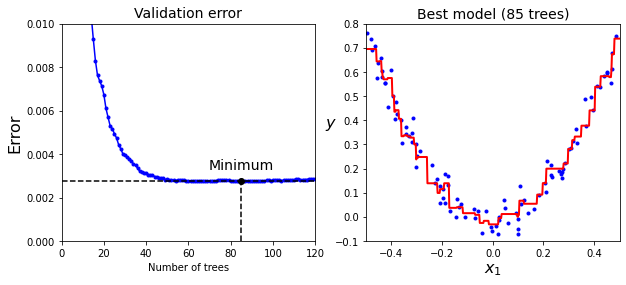

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs)

In [36]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [37]:
print(gbrt.n_estimators)

69


In [38]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002750279033345716


### 6.2.2 Extreme Gradient Boosting (XGBoost)

- Optimizd implementation of Gradient Boosting. 
- It aims to be extremely fast, scalable and portable. 
- XGBoost automatically take care of early stopping

In [39]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [40]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], 
            early_stopping_rounds=2)

y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22055
[1]	validation_0-rmse:0.16547
[2]	validation_0-rmse:0.12243
[3]	validation_0-rmse:0.10044
[4]	validation_0-rmse:0.08467
[5]	validation_0-rmse:0.07344
[6]	validation_0-rmse:0.06728
[7]	validation_0-rmse:0.06383
[8]	validation_0-rmse:0.06125
[9]	validation_0-rmse:0.05959
[10]	validation_0-rmse:0.05902
[11]	validation_0-rmse:0.05852
[12]	validation_0-rmse:0.05844
[13]	validation_0-rmse:0.05801
[14]	validation_0-rmse:0.05747
[15]	validation_0-rmse:0.05772


c:\Users\joann\Anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# 7. Stacking (Stacked Generalization)

- Based on the idea that instead of using trivial functions such as hard voting to aggregate the predictions of all predictors in an ensemble, we train a model to perform this aggregation.
- Each of the predictors predicts a different value (3.1, 2.7, 2.9), and the final predcitor (blender or metal learner) takes these predictions and as inputs and makes the final prediction (3.0)

![figure7.12](images/figure7.12.png)

To train the blender, we use hold-out set.  
- First we split training data into two subsets. First subset is used to train the predictors in the first layer.

![figure7.13](images/figure7.13.png)

- We use second subset as the hold-out set where we evaluate on.
- We have three predicted values.
- We can create a new training set using these predicted values as input features and keeping the target values.
- The blender is trained on this new training set so it leans to predict the target value, given the first layer's predictions

![figure7.14](images/figure7.14.png)